In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary

device = "cuda"

#Dead Kernel error
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#GPU 체크!
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

#시드 설정
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Wed Sep 14 22:20:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8    40W / 350W |   1584MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#데이터셋 CIFAR100
tp = transforms.ToTensor()
tt = transforms.ToPILImage()

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4,padding_mode="reflect"),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

trainset = datasets.CIFAR100(root='~/.torch', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='~/.torch', train=False, download=False, transform=transform_test)

Files already downloaded and verified


In [3]:
classes = np.array(list(trainset.class_to_idx.values()))
classes_test = np.array(list(testset.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99] 	Type: <class 'numpy.ndarray'>
Classes Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99] 	Type: <class 'numpy.ndarray'>


In [4]:
print("Image Shape: {}".format(trainset[0][0].size()))

Image Shape: torch.Size([3, 32, 32])


# Visualize

In [5]:
def imshow(img):
    plt.imshow(img, cmap='gray')

In [6]:
def visualize(dataset):
    figure = plt.figure(figsize=(25,4))
    for i in range(20):
        axis = figure.add_subplot(2, 10, i+1, xticks=[], yticks=[])
        data = dataset.data[i]
        
        target = dataset.targets[i]
        imshow(data)
        axis.set_title(target)

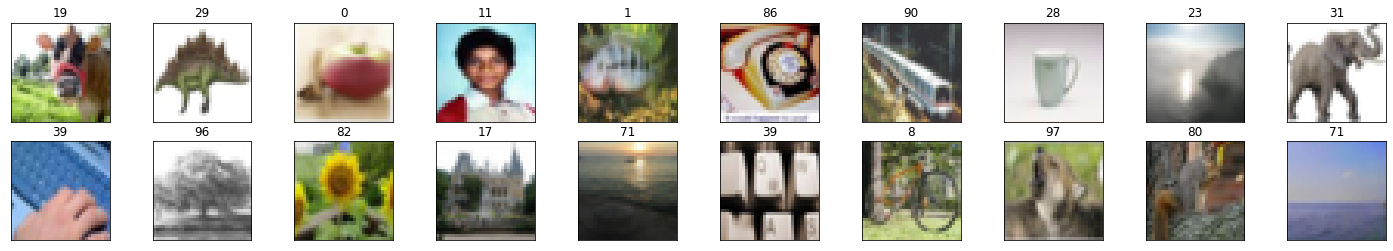

In [7]:
visualize(trainset)

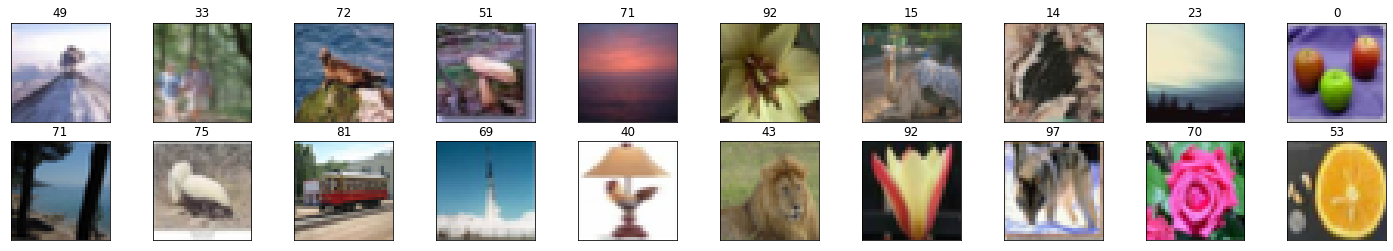

In [8]:
visualize(testset)

# Partitioning the data (non-IID)

In [9]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
    shard_idxs = [i for i in range(total_shards)]
    client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
    idxs = np.arange(len(dataset))
    data_labels = dataset.targets
    
    label_idxs = np.vstack((idxs, data_labels))
    label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
    idxs = label_idxs[0,:]
    for i in range(clients):
        rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
        shard_idxs = list(set(shard_idxs) - rand_set)
        
        for rand in rand_set:
            client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis = 0)
        
    return client_dict

# Models

In [15]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [16]:
resnet50 = ResNet50(100).to('cuda')

print("\nResNet-50 SUMMARY")
print(summary(resnet50, (3, 32,32)))


ResNet-50 SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,160
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,928
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,640
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,640
      BatchNorm2d-14

# FedAvg

## Local

In [17]:
class CustomDataset(Dataset):
    def __init__(self,dataset,idxs):
        self.dataset = dataset
        self.idxs = list(idxs)
        
    def __len__(self):
        return len(self.idxs)
    
    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label
    
class ClientUpdate(object):
    def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
        self.train_loader = DataLoader(CustomDataset(dataset,idxs), batch_size = batch_size, shuffle=True)
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        
    def train(self, model):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
        
        e_loss = []
        
        for epoch in range(1, self.epochs+1):
            train_loss = 0.0
            
            model.train()
            
            for data, labels in self.train_loader:
                data, labels = data.cuda(), labels.cuda()
                    
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*data.size(0)
                
            train_loss = train_loss/len(self.train_loader.dataset)
            e_loss.append(train_loss)
            
        total_loss = sum(e_loss)/len(e_loss)
        
        return model.state_dict(), total_loss

## Server

In [18]:
def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title, plt_color):
    #초기 global weight 정의
    global_weights = model.state_dict()
    train_loss = []
    start = time.time()
    
    #라운드 반복 시작
    for curr_round in range(1, rounds+1):
        w, local_loss = [], []
        #1보다 작은 숫자의 클라이언트 수를 선택할 수 없게 함.
        #C=0.1, K=20 이라하면, 아래 코드를 통해 랜덤하게 2개의 클라이언트를 선택하게 되는 것.
        m = max(int(C*K), 1)
        #클라이언트 랜덤 선택/ K개의 클라이언트 중 m개 선택
        S_t = np.random.choice(range(K),m,replace=False)
        
        #Avg 과정
        for k in S_t:
            #E 만큼의 epoch를 가지며, 각 클라이언트 업데이트 시작
            local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
            #local weight와 loss 추출
            weights, loss = local_update.train(model=copy.deepcopy(model))
            w.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))
        
        #global weights 업데이트
        weights_avg = copy.deepcopy(w[0])
        for k in weights_avg.keys():
            for i in range(1, len(w)):
                weights_avg[k] += w[i][k]
            weights_avg[k] = torch.div(weights_avg[k], len(w))
        global_weights = weights_avg
        
        #global model의 weight 변경
        model.load_state_dict(global_weights)
        
        #라운드와 local loss의 평균 출력
        loss_avg = sum(local_loss)/len(local_loss)
        print("Round: {}... \tAverage Loss: {}".format(curr_round, round(loss_avg, 3)))
        train_loss.append(loss_avg)
        
    end = time.time()
    fig, ax = plt.subplots()
    x_axis = np.arange(1, rounds+1)
    y_axis = np.array(train_loss)
    ax.plot(x_axis, y_axis, 'tab:'+plt_color)
    
    ax.set(xlabel="Number of Rounds", ylabel="Train Loss", title=plt_title)
    ax.grid()
    fig.savefig(plt_title+'.jpg', format='jpg')
    print("Training Done!")
    print("Total time taken to Train: {}".format(end-start))
    
    return model

## Testing Loop


In [19]:
def testing(model, dataset, bs, criterion, num_classes, classes):
    test_loss = 0.0
    correct_class = list(0. for i in range(num_classes))
    total_class = list(0. for i in range(num_classes))
    
    test_loader = DataLoader(dataset, batch_size=bs)
    I = len(test_loader)
    model.eval()
    for data, labels in test_loader:
        data, labels = data.cuda(), labels.cuda()
            
        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item()*data.size(0)
        
        _, pred = torch.max(output,1)
        
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        
        for i in range(num_classes):
        
            label = labels.data[i]
            correct_class[label] += correct[i].item()
            total_class[label] += 1
            
    test_loss = test_loss/len(test_loader.dataset)
    print("Test Loss: {:.6f}\n".format(test_loss))
        
    for i in range(10):
        if total_class[i] > 0:
            print("Test Accuracy of %5s: %2d%% (%2d/%2d)" 
                  %(classes[i],
                    100 * correct_class[i]/total_class[i],
                    np.sum(correct_class[i]),
                    np.sum(total_class[i])))
        else:
            print("Test Accuracy of %5s: N/A" % (classes[i]))
    print("\nFinal Test Accuracy: {:.3f} ({}/{})".format(100. * np.sum(correct_class)/np.sum(total_class),
                                                         np.sum(correct_class),
                                                         np.sum(total_class)))

# ResNet CIFAR100 non-iid

## Train

In [23]:
rounds = 100
C, K, E = 0.1, 100, 30
batch_size = 20
lr = 0.01
data_dict = non_iid_partition(trainset, 100, 200, 100, 2)
resnet50 = ResNet50(100)
resnet50.cuda()
cifar100_lenet_non_iid_trained = training(resnet50, rounds, batch_size, lr, trainset, data_dict, C, K, E, "CIFAR100 LeNet on Non-IID Dataset", "green")

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## Test

In [32]:
criterion = nn.CrossEntropyLoss()
testing(cifar100_lenet_non_iid_trained, trainset, 100, criterion, num_classes, classes_test)

Test Loss: 7.654095

Test Accuracy of     0: 60% (304/500)
Test Accuracy of     1: 15% (76/500)
Test Accuracy of     2: 53% (265/500)
Test Accuracy of     3: 42% (214/500)
Test Accuracy of     4: 13% (69/500)
Test Accuracy of     5: 28% (143/500)
Test Accuracy of     6:  1% ( 8/500)
Test Accuracy of     7: 10% (51/500)
Test Accuracy of     8:  9% (49/500)
Test Accuracy of     9: 55% (275/500)

Final Test Accuracy: 6.686 (3343.0/50000.0)
